In [23]:
!pip install PyPortfolioOpt
!pip install -U kaleido

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [8]:
import sys

print(sys.executable)
print(sys.version)
print(sys.version_info)

sys.path.append("C:\\Users\\steve\\git\\pylib") # go to parent dir
from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

from utils import *
from myInds import *


C:\Users\steve\miniconda3\envs\vectorbt\python.exe
3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=13, micro=5, releaselevel='final', serial=0)


In [11]:
# Define params
symbols = ['NFLX', 'GOOG', 'TSLA','COIN','MSTR','UNH','COST','TEM']
start_date = datetime(2023, 1, 1, tzinfo=pytz.utc)
end_date = datetime(2025, 5, 1, tzinfo=pytz.utc)
num_tests = 2000

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [14]:
tf='1D'
data = retrieve_data(tickers=symbols, tf=tf)

print(data.tickers)

[!] Loading All: NFLX, GOOG, TSLA, COIN, MSTR, UNH, COST, TEM
[i] Loaded NFLX[1D]: NFLX_1D.csv
[i] Runtime: 1316.0795 ms (1.3161 s)
[i] Loaded GOOG[1D]: GOOG_1D.csv
[i] Runtime: 1504.8186 ms (1.5048 s)
[i] Loaded TSLA[1D]: TSLA_1D.csv
[i] Runtime: 1544.1111 ms (1.5441 s)
[i] Loaded COIN[1D]: COIN_1D.csv
[i] Runtime: 1681.5643 ms (1.6816 s)
[i] Loaded MSTR[1D]: MSTR_1D.csv
[i] Runtime: 1510.5428 ms (1.5105 s)
[i] Loaded UNH[1D]: UNH_1D.csv
[i] Runtime: 1525.9114 ms (1.5259 s)
[i] Loaded COST[1D]: COST_1D.csv
[i] Runtime: 1519.4301 ms (1.5194 s)
[i] Loaded TEM[1D]: TEM_1D.csv
[i] Runtime: 1468.0089 ms (1.4680 s)
['NFLX', 'GOOG', 'TSLA', 'COIN', 'MSTR', 'UNH', 'COST', 'TEM']


In [39]:
ohlcv = pd.concat(data.data, axis=1)
ohlcv_long = ohlcv.stack(level=0)
print(ohlcv_long.keys())
print(ohlcv_long[:10])

Index(['close', 'high', 'low', 'open', 'trade_count', 'volume', 'vwap',
       'Datetime', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200',
       'SMA_250', 'SMA_375', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0',
       'BBB_20_2.0', 'BBP_20_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'RSI_14', 'PPO_12_26_9', 'PPOh_12_26_9',
       'PPOs_12_26_9', 'CUMLOGRET_1'],
      dtype='object')
                                  close       high  ...  PPOs_12_26_9  \
Datetime                                            ...                 
2020-08-05 04:00:00+00:00 COST   339.97   342.7300  ...           NaN   
                          GOOG  1473.61  1482.4100  ...           NaN   
                          MSTR   123.95   125.1700  ...           NaN   
                          NFLX   502.11   510.1021  ...           NaN   
                          TSLA  1485.02  1499.8384  ...           NaN   
                          UNH    312.47   312.9600  ...           NaN   

C:\Users\steve\AppData\Local\Temp\ipykernel_23616\3534496312.py:2: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [42]:
price = ohlcv_long['close']
print(price[:10])

Datetime                       
2020-08-05 04:00:00+00:00  COST     339.97
                           GOOG    1473.61
                           MSTR     123.95
                           NFLX     502.11
                           TSLA    1485.02
                           UNH      312.47
2020-08-06 04:00:00+00:00  COST     343.31
                           GOOG    1500.10
                           MSTR     123.35
                           NFLX     509.08
Name: close, dtype: float64


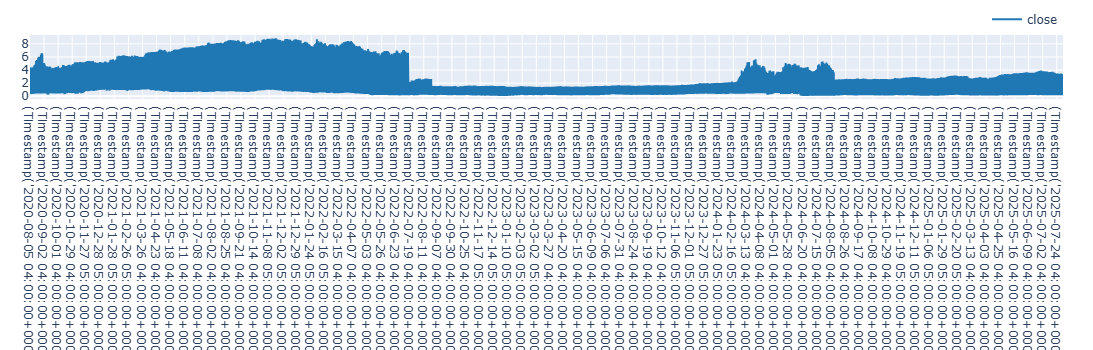

In [43]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show()

In [48]:
returns = price.unstack().pct_change()

In [49]:
print(returns.mean())

COIN    0.001492
COST    0.000924
GOOG    0.000207
MSTR    0.003717
NFLX    0.001069
TEM     0.003765
TSLA    0.000440
UNH    -0.000046
dtype: float64


In [50]:
print(returns.std())

COIN    0.055685
COST    0.014235
GOOG    0.033199
MSTR    0.065231
NFLX    0.027829
TEM     0.074186
TSLA    0.049266
UNH     0.018264
dtype: float64


In [51]:
print(returns.corr())

          COIN      COST  ...      TSLA       UNH
COIN  1.000000  0.294050  ...  0.417322  0.039401
COST  0.294050  1.000000  ...  0.283904  0.204838
GOOG  0.199267  0.254025  ...  0.184989  0.115020
MSTR  0.630226  0.212332  ...  0.292780  0.065926
NFLX  0.371320  0.351043  ...  0.272479  0.054653
TEM   0.442162  0.241545  ...  0.379475  0.156842
TSLA  0.417322  0.283904  ...  1.000000  0.065223
UNH   0.039401  0.204838  ...  0.065223  1.000000

[8 rows x 8 columns]


## vectorbt: Random search

### One-time allocation

In [52]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [53]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

ValueError: all arrays must be same length

In [13]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(754, 10000)


In [14]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

10000


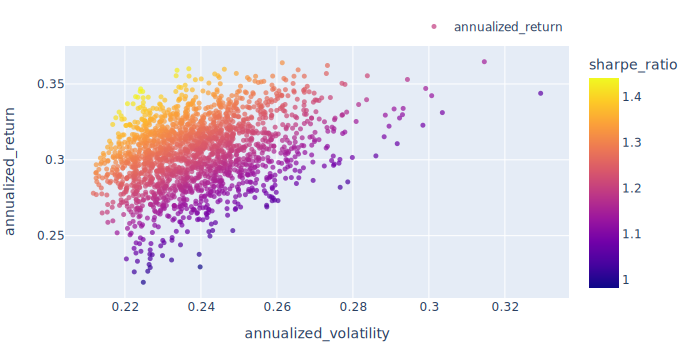

In [15]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [16]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

214


In [17]:
# Print best weights
print(weights[best_symbol_group])

[0.18782144 0.14807743 0.0266817  0.01132979 0.62608964]


In [18]:
# Compute default stats
print(pf.iloc[best_symbol_group].stats())

Start                         2017-01-03 00:00:00+00:00
End                           2019-12-31 00:00:00+00:00
Period                                754 days 00:00:00
Start Value                                       100.0
End Value                                    243.693256
Total Return [%]                             143.693256
Benchmark Return [%]                         121.870057
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              33.993899
Max Drawdown Duration                 277 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   0
Total Open Trades                                     5
Open Trade PnL                               143.693256
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Rebalance monthly

In [19]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

36


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [20]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(754, 10000)


In [21]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

359995


In [22]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

214


In [23]:
print(weights[rb_best_symbol_group])

[0.18782144 0.14807743 0.0266817  0.01132979 0.62608964]


In [24]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                           2017-01-03 00:00:00+00:00
End                             2019-12-31 00:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      248.651338
Total Return [%]                               148.651338
Benchmark Return [%]                           121.870057
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                33.258623
Max Drawdown Duration                   256 days 00:00:00
Total Trades                                           92
Total Closed Trades                                    87
Total Open Trades                                       5
Open Trade PnL                                 117.477516
Win Rate [%]                                    97.701149
Best Trade [%]                                 189.769858
Worst Trade [%

In [25]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

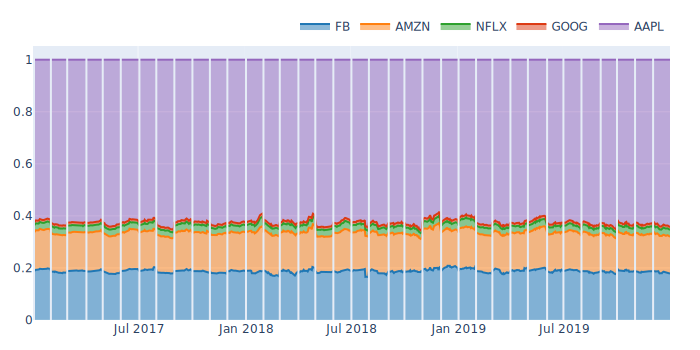

In [26]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [27]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    weights = np.full(c.group_len, np.nan, dtype=np.float64)
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def pre_segment_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float64)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return order_nb(
        weights[col_i], 
        c.close[c.i, c.col],
        size_type=SizeType.TargetPercent
    )

In [28]:
ann_factor = returns.vbt.returns.ann_factor

In [29]:
# Run simulation using a custom order function
srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True
)

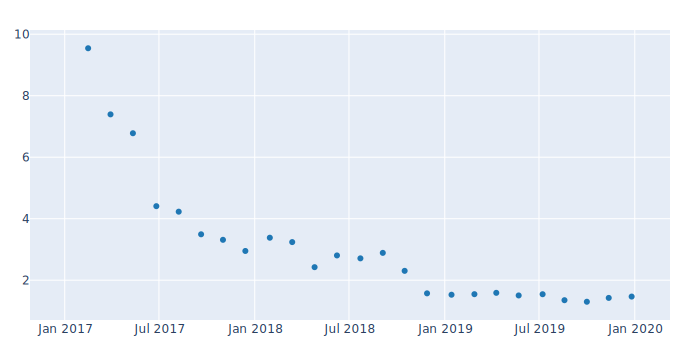

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [31]:
print(srb_pf.stats())

Start                           2017-01-03 00:00:00+00:00
End                             2019-12-31 00:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      182.103898
Total Return [%]                                82.103898
Benchmark Return [%]                           121.870057
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                34.350877
Max Drawdown Duration                   310 days 00:00:00
Total Trades                                           67
Total Closed Trades                                    62
Total Open Trades                                       5
Open Trade PnL                                  33.965423
Win Rate [%]                                    77.419355
Best Trade [%]                                   43.78028
Worst Trade [%

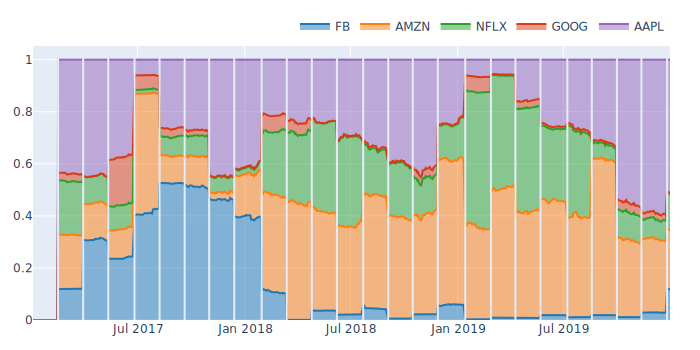

In [32]:
plot_allocation(srb_pf)

You can see how weights stabilize themselves with growing data.

In [33]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True
)

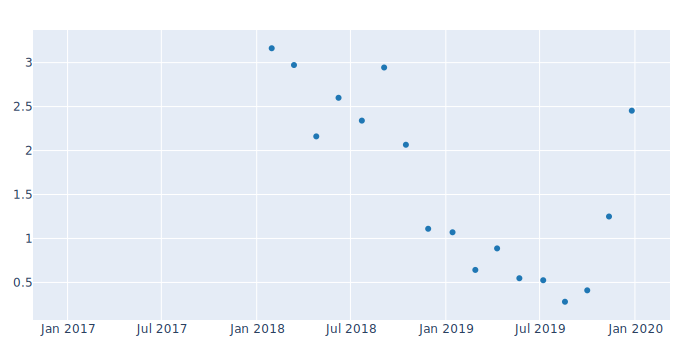

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [35]:
print(srb252_pf.stats())

Start                           2017-01-03 00:00:00+00:00
End                             2019-12-31 00:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      138.658042
Total Return [%]                                38.658042
Benchmark Return [%]                           121.870057
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                33.135977
Max Drawdown Duration                   192 days 00:00:00
Total Trades                                           39
Total Closed Trades                                    34
Total Open Trades                                       5
Open Trade PnL                                  10.464979
Win Rate [%]                                    58.823529
Best Trade [%]                                  16.361723
Worst Trade [%

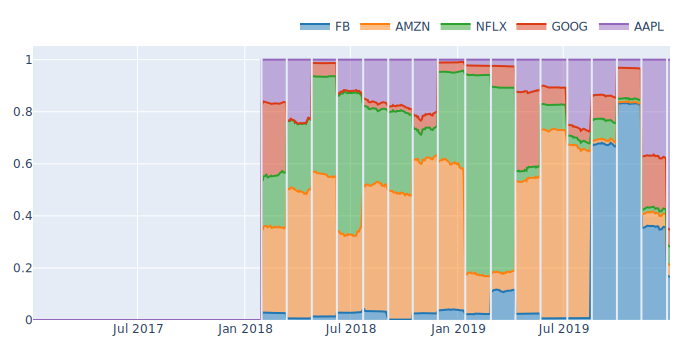

In [36]:
plot_allocation(srb252_pf)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [37]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.22232 0.06347 0.      0.7142 ]


In [38]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(754, 5)


In [39]:
# Run simulation with weights from PyPortfolioOpt
pyopt_pf = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True
)

print(len(pyopt_pf.orders))

3


Faster than stacking solution, but doesn't let you compare weights.

In [40]:
print(pyopt_pf.stats())

Start                         2017-01-03 00:00:00+00:00
End                           2019-12-31 00:00:00+00:00
Period                                754 days 00:00:00
Start Value                                       100.0
End Value                                    259.637702
Total Return [%]                             159.637702
Benchmark Return [%]                         121.870057
Max Gross Exposure [%]                        99.999615
Total Fees Paid                                     0.0
Max Drawdown [%]                               35.25499
Max Drawdown Duration                 266 days 00:00:00
Total Trades                                          3
Total Closed Trades                                   0
Total Open Trades                                     3
Open Trade PnL                               159.637702
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Search and rebalance monthly

You can't use third-party optimization packages within Numba (yet).

Here you have two choices:
1) Use `os.environ['NUMBA_DISABLE_JIT'] = '1'` before all imports to disable Numba completely
2) Disable Numba for the function, but also for every other function in the stack that calls it

We will demonstrate the second option.

In [41]:
def pyopt_find_weights(sc, price, num_tests):  # no @njit decorator = it's a pure Python function
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [42]:
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function
pyopt_srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb.py_func,  # run pre_segment_func_nb as pure Python function
    pre_segment_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    use_numba=False  # run simulate_nb as pure Python function
)

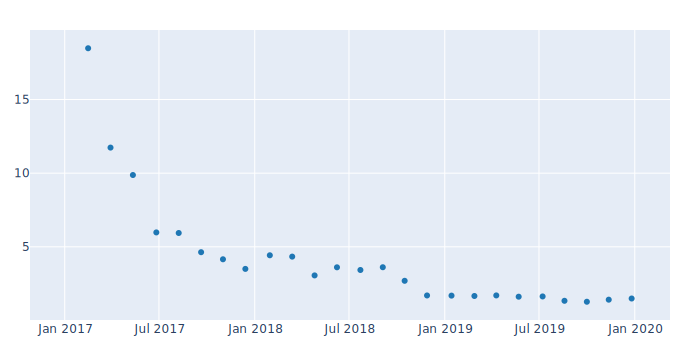

In [43]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [44]:
print(pyopt_srb_pf.stats())

Start                         2017-01-03 00:00:00+00:00
End                           2019-12-31 00:00:00+00:00
Period                                754 days 00:00:00
Start Value                                       100.0
End Value                                    166.711167
Total Return [%]                              66.711167
Benchmark Return [%]                         121.870057
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              35.363921
Max Drawdown Duration                 333 days 00:00:00
Total Trades                                         44
Total Closed Trades                                  41
Total Open Trades                                     3
Open Trade PnL                                27.442055
Win Rate [%]                                   78.04878
Best Trade [%]                                35.953901
Worst Trade [%]                              -30

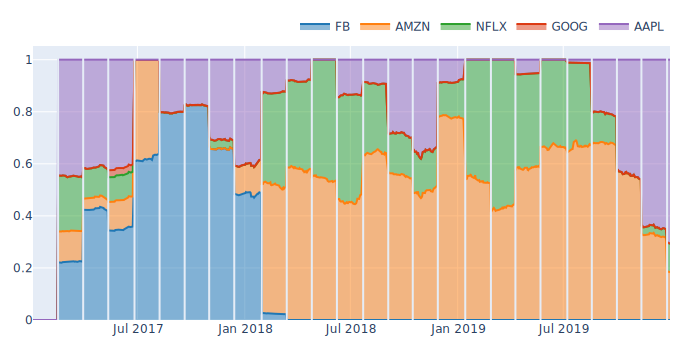

In [45]:
plot_allocation(pyopt_srb_pf)